<a href="https://colab.research.google.com/github/Nov05/Google-Colaboratory/blob/master/2019_11_22_Random_forest_predicting_time_series_data_(stock_price).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# modified by nov05 on 2019-11-22

# Microsoft (MSFT) stock price vs. Other stock price

Predict stock price from prices of other stocks

# Load data

Data collected from yahoo finance on 11/12/2019

In [0]:
!pip install --upgrade category_encoders
!pip install pandas-profiling 
!pip install plotly
!pip install pdpbox

# Imports

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from pdpbox.pdp import pdp_isolate
from pdpbox.pdp import pdp_plot
from pdpbox.pdp import pdp_interact
from pdpbox.pdp import pdp_interact_plot

import plotly.graph_objs as go

%matplotlib inline

In [0]:
url = 'https://drive.google.com/uc?id=11rtqxbyxURvSIDEHafmaemMj4sEHV2oP'
df = pd.read_csv(url)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Apply datetime to date column
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

print(df.shape)
df.head(3)

(4778, 16)


,date,open_msft,high_msft,low_msft,msft,volume_msft,aapl,amzn,orcl,ibm,jnj,cvs,ko,tgt,wmt,fdx
0,2000-11-13,33.34375,34.06250,32.203125,21.444250,83364800,1.204157,27.8125,21.645746,64.482780,28.172709,21.310297,13.498687,18.296497,31.713482,40.674557
1,2000-11-14,34.00000,34.90625,33.656250,22.210835,84218600,1.258539,28.9375,24.816080,65.847733,28.645721,21.286823,13.388154,19.693838,32.807064,41.105827
2,2000-11-15,34.53125,35.43750,34.343750,22.614307,60422200,1.235233,29.5000,25.253365,65.765007,28.759243,20.254168,13.553953,20.174177,34.294323,42.687160


In [0]:
df.dtypes

date           datetime64[ns]
open_msft             float64
high_msft             float64
low_msft              float64
msft                  float64
volume_msft             int64
aapl                  float64
amzn                  float64
orcl                  float64
ibm                   float64
jnj                   float64
cvs                   float64
ko                    float64
tgt                   float64
wmt                   float64
fdx                   float64
dtype: object

In [0]:
# Checking for null values
df.isnull().sum()

date           0
open_msft      0
high_msft      0
low_msft       0
msft           0
volume_msft    0
aapl           0
amzn           0
orcl           0
ibm            0
jnj            0
cvs            0
ko             0
tgt            0
wmt            0
fdx            0
dtype: int64

In [0]:
# summary stats
print(df.describe())

         open_msft    high_msft  ...          wmt          fdx
count  4778.000000  4778.000000  ...  4778.000000  4778.000000
mean     41.602737    42.002494  ...    52.857089   106.364977
std      27.160511    27.335819  ...    20.092679    54.144649
min      15.200000    15.620000  ...    30.879402    30.952911
25%      26.370001    26.660000  ...    37.713664    70.030728
50%      29.345000    29.650000  ...    42.861773    87.512119
75%      45.387501    45.695000  ...    65.721882   145.516300
max     145.339996   146.419998  ...   120.239998   268.354980

[8 rows x 15 columns]


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


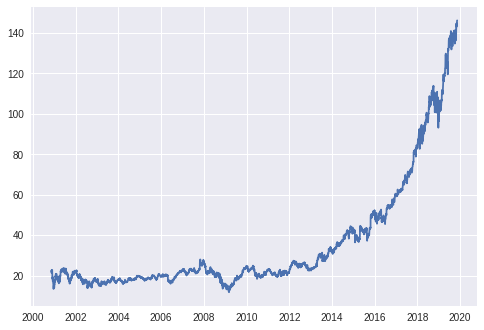

In [0]:
# check target column
plt.style.use('seaborn')
plt.plot(df['date'], df['msft']);

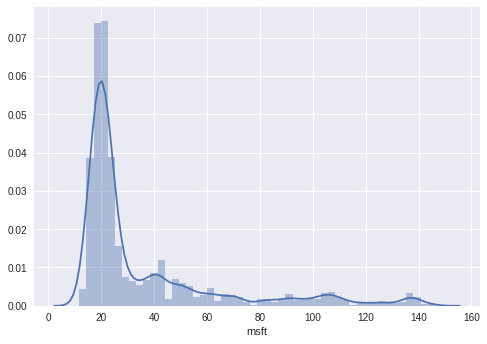

In [0]:
# distribution is skewed
sns.distplot(df['msft']);

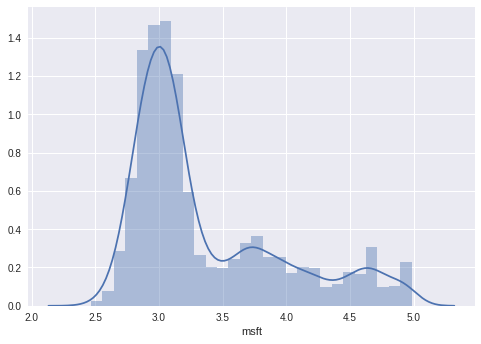

In [0]:
# log value to reduce skewness
sns.distplot(np.log(df['msft']));

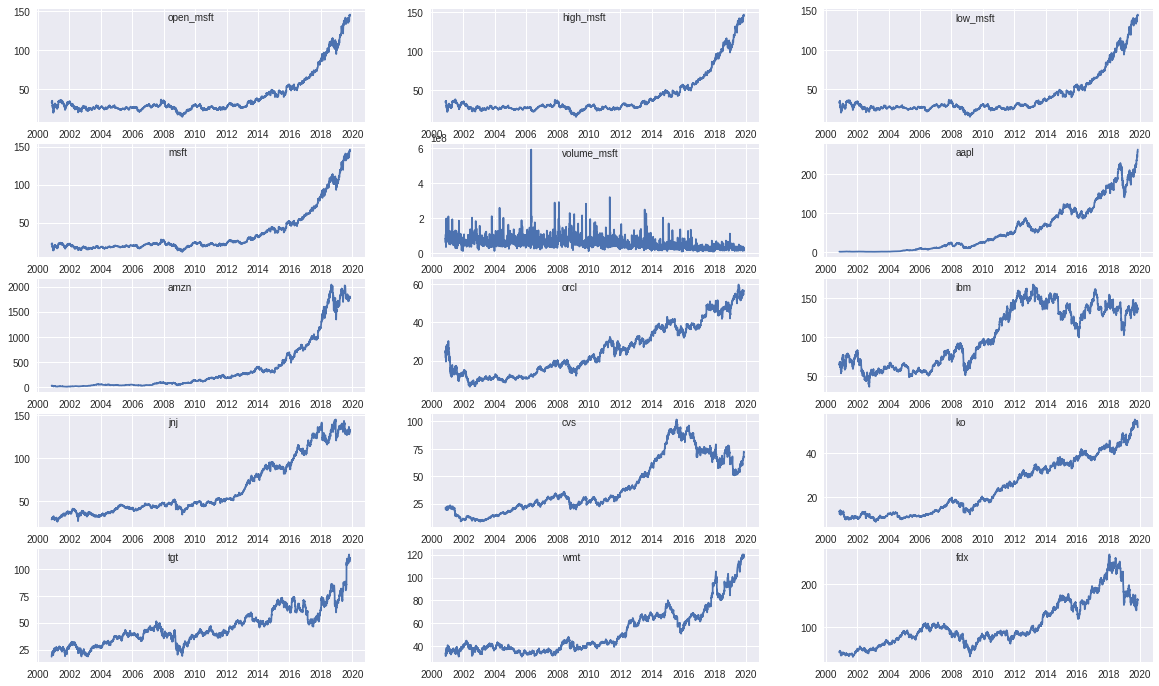

In [0]:
fig, axes = plt.subplots(5, 3, figsize=(20, 12))
for i,col in enumerate(df.columns[1:]):
    ax = axes.flat[i]
    ax.plot(df['date'], df[col])
    ax.text(0.4, 0.9, col, transform=ax.transAxes);
    
# check all the time series
# choose msft as target later. what would cause data leakage?
# probably shouldn't use open_msft, high_msft, low_msft as features

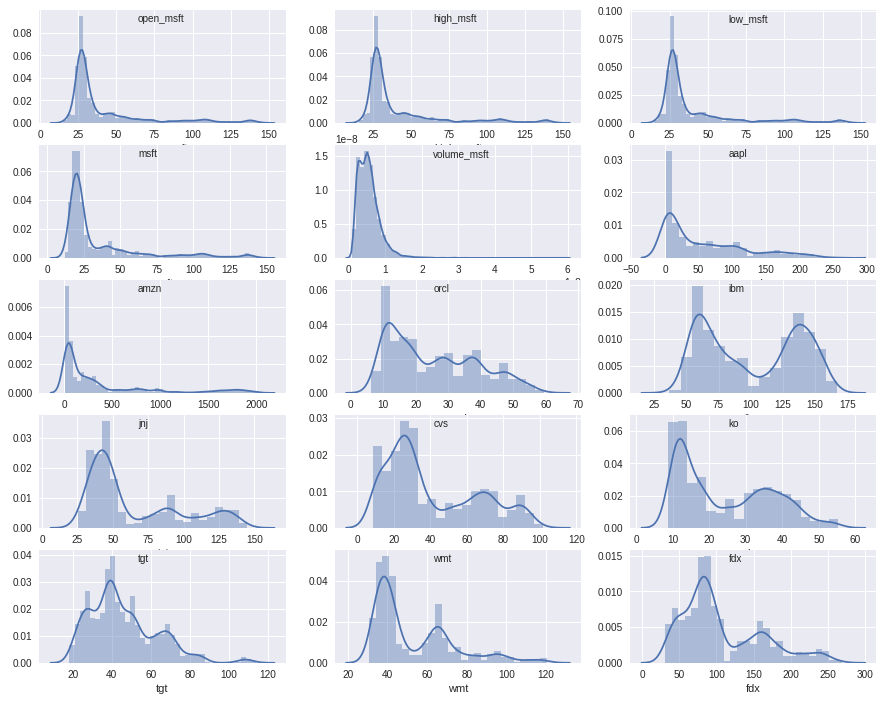

In [0]:
# all columns are skewed, use log value to reduce skewness
fig, axes = plt.subplots(5, 3, figsize=(15, 12))
for i,col in enumerate(df.columns[1:]):
    ax = axes.flat[i]
    sns.distplot(df[col], ax=ax)
    ax.text(0.4, 0.9, col, transform=ax.transAxes);

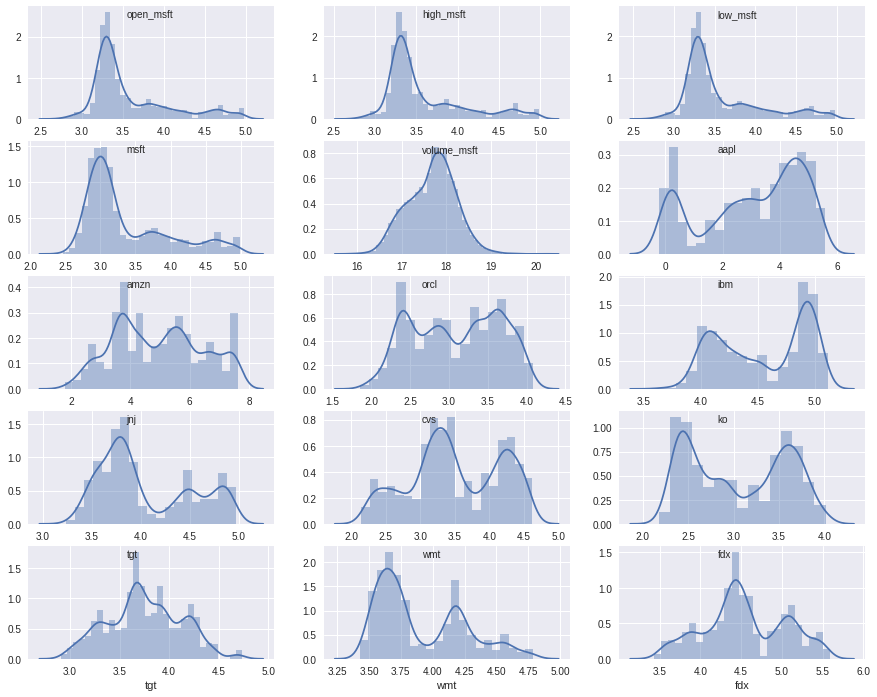

In [0]:
# check log value distribution
fig, axes = plt.subplots(5, 3, figsize=(15, 12))
for i,col in enumerate(df.columns[1:]):
    ax = axes.flat[i]
    sns.distplot(np.log(df[col]), ax=ax)
    ax.text(0.4, 0.9, col, transform=ax.transAxes);

# Split the data


In [0]:
num_test = int(len(df)*0.3)
num_train = len(df) - num_test

train = df[:num_train]
test = df[num_train:]

train.shape, test.shape

((3345, 16), (1433, 16))

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html   

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation. 

**Notes**

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

The autolag option and maxlag for it are described in Greene.

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
 
    X['year'] = X['date'].dt.year
    
    # where does this mean price come from?!
    # wouldn't it introduce data leakage?
    # Obtain the msft_daily_volatility column
    # daily stock price = X['msft']
    mean_price = 35.840448
    X['msft_daily_volatility'] = (mean_price - X['msft'])**2
    
    # Transform the time series to stationary
    # also use log value to reduce skewness
    cols = ['msft','aapl','amzn','orcl','ibm','jnj','cvs','ko','tgt','wmt',
            'fdx','open_msft','high_msft','low_msft','volume_msft',
            'msft_daily_volatility']
    for col in cols:
        X[col] = np.log(X[col]) - np.log(X[col].shift(1))
    
    # NaN in the first row of log_return
    X.dropna(inplace=True)
    
    # Verify the time series to stationarity
    for col in cols:
        # Augmented Dickey-Fuller test
        result = adfuller(X[col])
        print(col, 'p-value: %f' % result[1])
    print()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
test = wrangle(test)

msft p-value: 0.000000
aapl p-value: 0.000000
amzn p-value: 0.000000
orcl p-value: 0.000000
ibm p-value: 0.000000
jnj p-value: 0.000000
cvs p-value: 0.000000
ko p-value: 0.000000
tgt p-value: 0.000000
wmt p-value: 0.000000
fdx p-value: 0.000000
open_msft p-value: 0.000000
high_msft p-value: 0.000000
low_msft p-value: 0.000000
volume_msft p-value: 0.000000
msft_daily_volatility p-value: 0.000000

msft p-value: 0.000000
aapl p-value: 0.000000
amzn p-value: 0.000000
orcl p-value: 0.000000
ibm p-value: 0.000000
jnj p-value: 0.000000
cvs p-value: 0.000000
ko p-value: 0.000000
tgt p-value: 0.000000
wmt p-value: 0.000000
fdx p-value: 0.000000
open_msft p-value: 0.000000
high_msft p-value: 0.000000
low_msft p-value: 0.000000
volume_msft p-value: 0.000000
msft_daily_volatility p-value: 0.000000



All the series was transformed to stationary, they got p-value = 0

In [0]:
print(train.shape)
train.head(2)

(3344, 18)


,date,open_msft,high_msft,low_msft,msft,volume_msft,aapl,amzn,orcl,ibm,jnj,cvs,ko,tgt,wmt,fdx,year,msft_daily_volatility
1,2000-11-14,0.019490,0.024469,0.044135,0.035124,0.010190,0.044172,0.039653,0.136683,0.020947,0.016650,-0.001102,-0.008222,0.073596,0.033902,0.010547,2000,-0.109439
2,2000-11-15,0.015504,0.015105,0.020221,0.018003,-0.332059,-0.018692,0.019252,0.017468,-0.001257,0.003955,-0.049728,0.012308,0.024098,0.044336,0.037748,2000,-0.060099


In [0]:
# summary stats
print(train.describe())

         open_msft    high_msft  ...         year  msft_daily_volatility
count  3344.000000  3344.000000  ...  3344.000000            3344.000000
mean      0.000041     0.000035  ...  2007.027811              -0.001130
std       0.018758     0.016486  ...     3.841864               0.072307
min      -0.126620    -0.121781  ...  2000.000000              -0.827217
25%      -0.008795    -0.007092  ...  2004.000000              -0.025583
50%       0.000000     0.000000  ...  2007.000000               0.000000
75%       0.008624     0.007138  ...  2010.000000               0.023615
max       0.131589     0.131852  ...  2014.000000               1.024768

[8 rows x 17 columns]


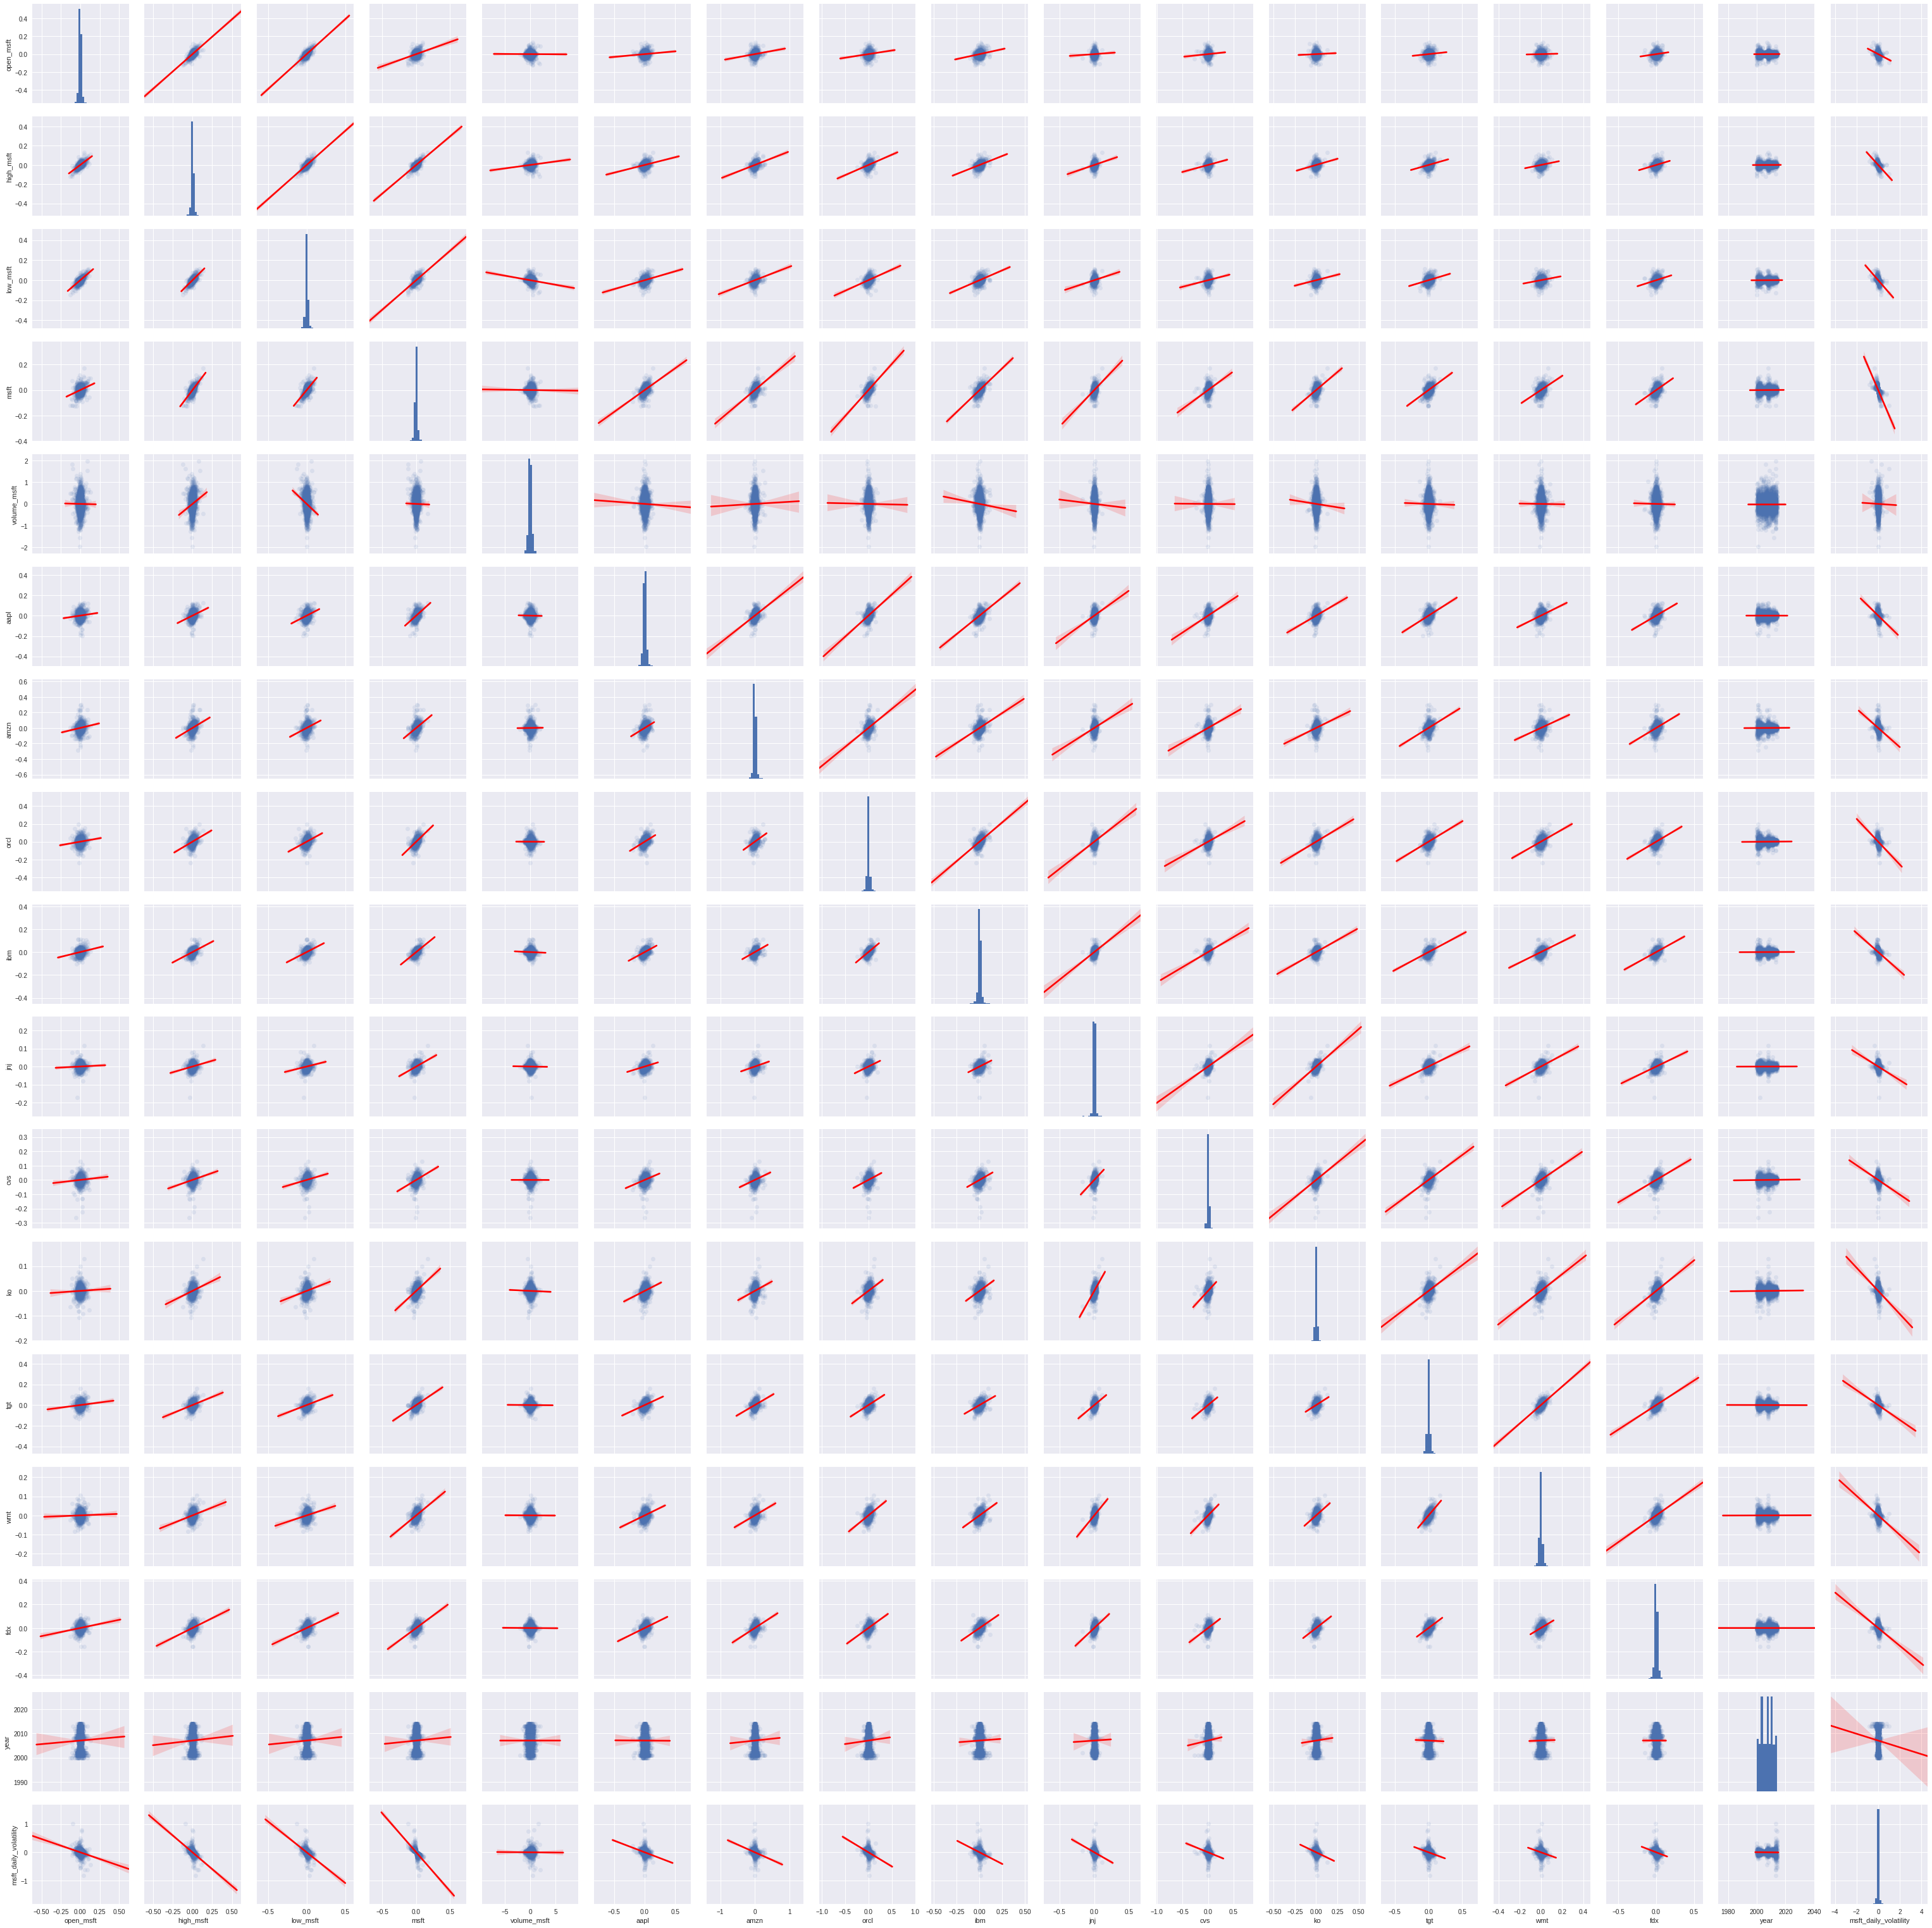

In [0]:
# sns.pairplot(train, alpha=0.5);
sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'red'}, 
                                          'scatter_kws':{'alpha': 0.1}});

In [0]:
# features = train.columns.drop(['msft'])
# for feature in features:
#     sns.scatterplot(x=feature, y='msft', data=train, alpha=0.1)
#     plt.show()

In [0]:
# train.profile_report()

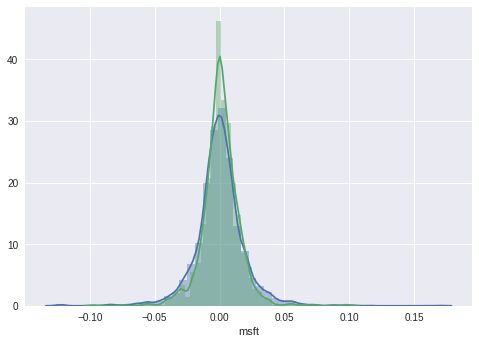

In [0]:
# make sure train and test data have similar distribution
sns.distplot(train['msft'])
sns.distplot(test['msft']);

# Baseline

In [0]:
# Mean baseline
y_train = train['msft']
y_test = test['msft']
y_pred_train = [y_train.mean()] * len(y_train)
y_pred_test  = [y_train.mean()] * len(y_test)

print('Mean Baseline:')
print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
print('Train R^2 Score:', r2_score(y_train, y_pred_train))
print('Test R^2 Score:', r2_score(y_test, y_pred_test))

Mean Baseline:
Train Mean Absolute Error: 0.013101663289578548
Test Mean Absolute Error: 0.009923733653101183
Train R^2 Score: 0.0
Test R^2 Score: -0.0038265865449615966


# Select features and target

In [0]:
target = 'msft'
cols_drop = [target, 'date', 
             'open_msft', 'high_msft', 'low_msft', 
             'msft_daily_volatility']

# Arrange data into X features matrix and y target vector
# X_train = train.drop(columns=target)
X_train = train.drop(columns=cols_drop)
y_train = train[target]

# X_test = test.drop(columns=target)
X_test = test.drop(columns=cols_drop)
y_test = test[target]

In [0]:
X_train.columns

Index(['volume_msft', 'aapl', 'amzn', 'orcl', 'ibm', 'jnj', 'cvs', 'ko', 'tgt',
       'wmt', 'fdx', 'year'],
      dtype='object')

# Random Forest

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

# with 'msft_daily_volatility' <- this is data leakage too
# MAE for 3 folds: [0.00446782 0.00392063 0.00803523]

MAE for 3 folds: [0.01074861 0.00961678 0.00768159]


In [0]:
from sklearn.metrics import mean_absolute_error
pipeline.fit(X_train, y_train)
y_pred_test = pipeline.predict(X_test)
mae_test = mean_absolute_error(y_pred_test, y_test)
print("test MAE:", mae_test)
print('Test R^2 Score:', r2_score(y_test, y_pred_test))

test MAE: 0.00727295569586215
Test R^2 Score: 0.4654083925822552


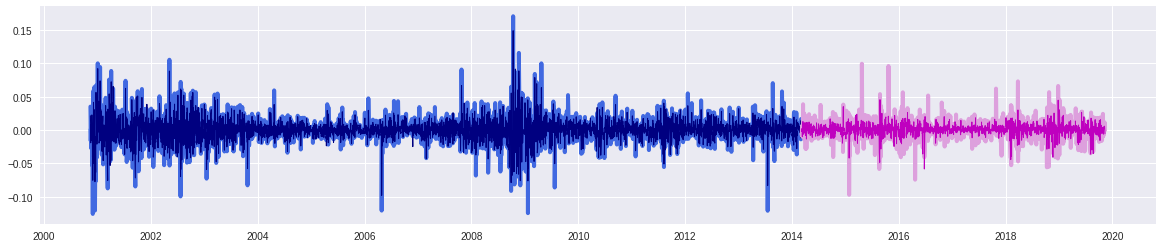

In [0]:
# Visualize predictions in log value
y_pred_train = pipeline.predict(X_train)

plt.figure(figsize=(20,4))
plt.plot(train['date'], y_train, color='royalblue',linewidth=4)
plt.plot(train['date'], y_pred_train, color='navy', linewidth=1)
plt.plot(test['date'], y_test, color='plum', linewidth=4)
plt.plot(test['date'], y_pred_test, color='m', linewidth=1);

# blue = train data, pink = test data
# light = real data, dark = predicted data

In [0]:
# reverse the following equition
# X[col] = np.log(X[col]) - np.log(X[col].shift(1)) 
y_pred_test2 = [np.log(df.loc[test.index[0]]['msft'])]
for i in range(len(y_pred_test)):
    y_pred_test2.append(y_pred_test2[i] + y_pred_test[i])

y_pred_test2 = np.exp(y_pred_test2)
print("number of predictions from test data:", len(y_pred_test2))
y_pred_test2

number of predictions from test data: 1433


array([33.480068  , 33.4094836 , 33.41386552, ..., 77.65020296,
       78.10345132, 77.67160477])

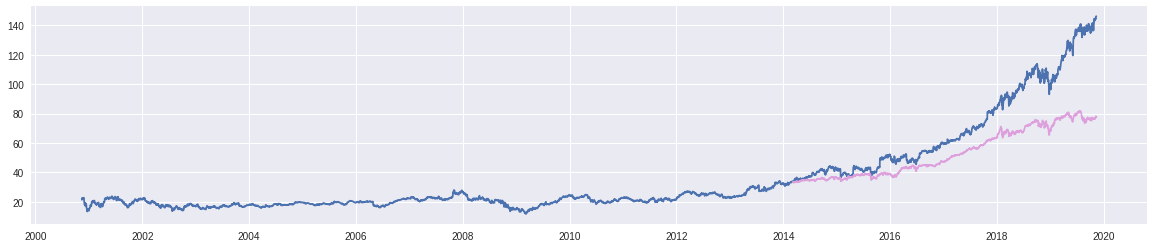

In [0]:
# Visualize prediction
plt.figure(figsize=(20,4))
plt.plot(df['date'], df[target])
plt.plot(df['date'][-test.shape[0]-1:], y_pred_test2, color='plum');

# blue = real data, pink = predicted data

In [0]:
df2 = wrangle(df)
X_all = df2.drop(columns=cols_drop)
y_all = df2[target]
y_pred_all = pipeline.predict(X_all)
print("number of predictions from all data:", len(y_pred_all))

msft p-value: 0.000000
aapl p-value: 0.000000
amzn p-value: 0.000000
orcl p-value: 0.000000
ibm p-value: 0.000000
jnj p-value: 0.000000
cvs p-value: 0.000000
ko p-value: 0.000000
tgt p-value: 0.000000
wmt p-value: 0.000000
fdx p-value: 0.000000
open_msft p-value: 0.000000
high_msft p-value: 0.000000
low_msft p-value: 0.000000
volume_msft p-value: 0.000000
msft_daily_volatility p-value: 0.000000

number of predictions from all data: 4777


In [0]:
l1 = [i for i in range(1, 10)]
s1 = pd.Series(l1)
s2 = s1.shift(1)
print(s1.to_list())
print(s2.to_list())
print((s1-s2).to_list())

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [0]:
# reverse the following equition
# X[col] = np.log(X[col]) - np.log(X[col].shift(1)) 
y_pred_all2 = [np.log(df[target].to_list()[0])]
for i in range(len(y_pred_all)):
    y_pred_all2.append(y_pred_all2[i] + y_pred_all[i])

y_pred_all2 = np.exp(y_pred_all2)
print("number of predctions from all data:", len(y_pred_all2))
y_pred_all2

number of predctions from all data: 4778


array([21.44425   , 21.90954288, 22.09094842, ..., 75.12840822,
       75.56693674, 75.14911498])

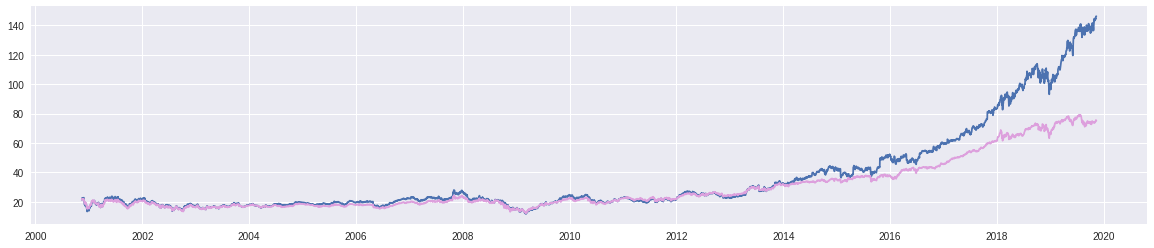

In [0]:
# Visualize prediction
plt.figure(figsize=(20,4))
plt.plot(df['date'], df[target])
plt.plot(df['date'], y_pred_all2, color='plum');

# blue = real data, pink = predicted data

# Random forest feature importances

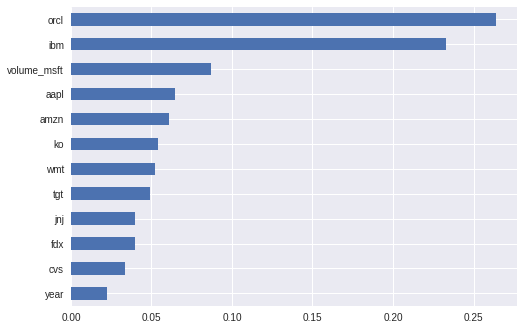

In [0]:
pd.Series(pipeline['randomforestregressor'].feature_importances_,
          X_train.columns).sort_values().plot.barh();

# Predict with original values (not with log values)

In [0]:
def wrangle2(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    X['year'] = X['date'].dt.year
    
    # Transform the time series to stationary
    cols = ['msft','aapl','amzn','orcl','ibm','jnj','cvs','ko',
            'tgt','wmt','fdx','open_msft','high_msft','low_msft',
            'volume_msft']
    for col in cols:
        X[col] = X[col] - X[col].shift(1)
    
    # NaN in the first row of log_return
    X.dropna(inplace=True)
   
    # return the wrangled dataframe
    return X

train = df[:num_train]
test = df[num_train:]

train = wrangle2(train)
test = wrangle2(test)

target = 'msft'
cols_drop = [target, 'date', 
             'open_msft', 'high_msft', 'low_msft']

# Arrange data into X features matrix and y target vector
# X_train = train.drop(columns=target)
X_train = train.drop(columns=cols_drop)
y_train = train[target]

# X_test = test.drop(columns=target)
X_test = test.drop(columns=cols_drop)
y_test = test[target]

In [0]:
pipeline2 = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)
k = 3
scores = cross_val_score(pipeline2, X_train, y_train, cv=k, 
                         scoring='neg_mean_squared_error')
print(f'MSE for {k} folds:', -scores)

MSE for 3 folds: [0.09806466 0.08516884 0.09801936]


In [0]:
pipeline2.fit(X_train, y_train)
y_pred_test = pipeline2.predict(X_test)
mean_absolute_error(y_pred_test, y_test)

0.5954070069518904

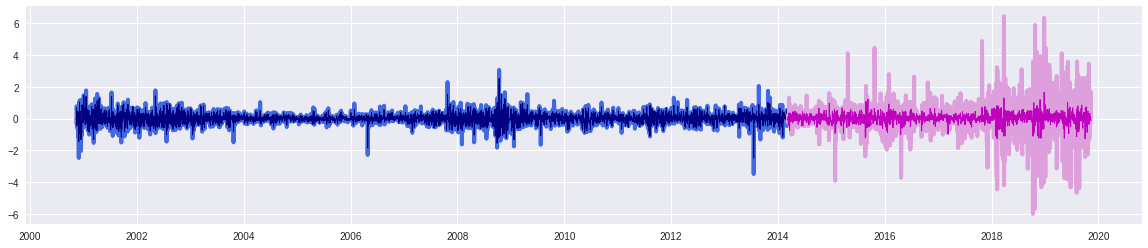

In [0]:
# Visualize predictions in log value
y_pred_train = pipeline2.predict(X_train)

plt.figure(figsize=(20,4))
plt.plot(train['date'], y_train, color='royalblue',linewidth=4)
plt.plot(train['date'], y_pred_train, color='navy', linewidth=1)
plt.plot(test['date'], y_test, color='plum', linewidth=4)
plt.plot(test['date'], y_pred_test, color='m', linewidth=1);

# blue = train data, pink = test data
# light = real data, dark = predicted data

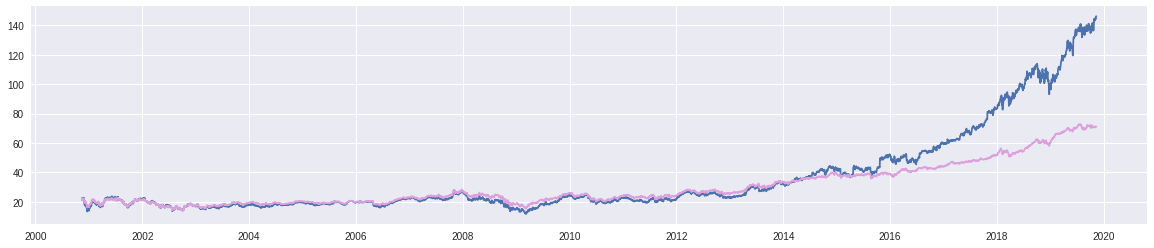

In [0]:
df2 = wrangle2(df)
X_all = df2.drop(columns=cols_drop)
y_all = df2[target]
y_pred_all = pipeline2.predict(X_all)

# reverse the following equition
# X[col] = X[col] - X[col].shift(1))
y_pred2 = [df[target].to_list()[0]]
for i in range(len(y_pred_all)):
    y_pred2.append(y_pred2[i] + y_pred_all[i])

# Visualize prediction
plt.figure(figsize=(20,4))
plt.plot(df['date'], df[target])
plt.plot(df['date'], y_pred2, color='plum');

# Similar to predictions with log values
# Using log or not will get similar predictions
# Engineering a feature of year improves performance
# the curse seems overfitted...

# Partial importance - Oracle

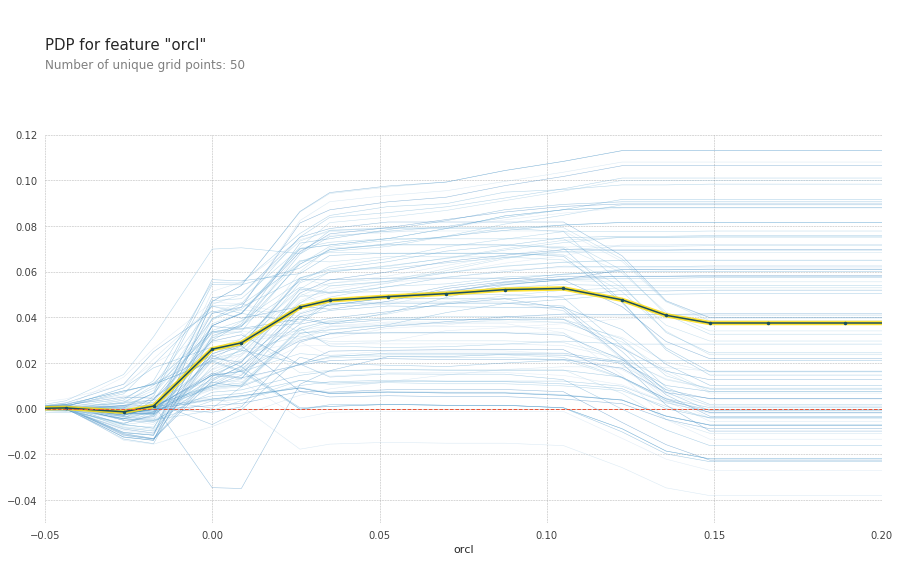

In [0]:
feature = 'orcl'
isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature,
    num_grid_points=50
)
# Plot PDP with 100 ICE curves
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature,
         plot_lines=True, frac_to_plot=100);
plt.xlim(-0.05, 0.2)
plt.ylim(-0.05, 0.12);

# Partial importance - IBM

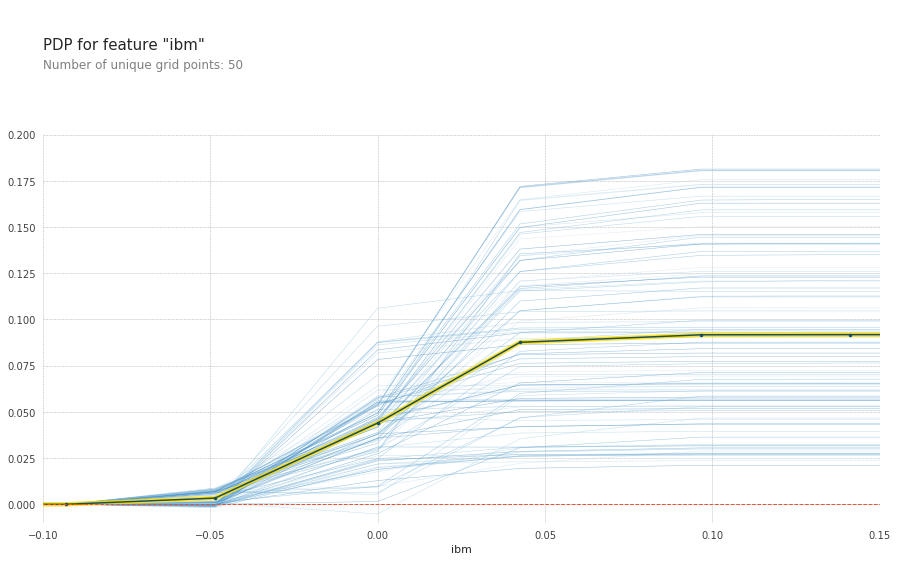

In [0]:
feature = 'ibm'
isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature,
    num_grid_points=50
)
# Plot PDP with 100 ICE curves
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature,
         plot_lines=True, frac_to_plot=100);
plt.xlim(-0.1, 0.15)
plt.ylim(-0.01, 0.2);

# Partial importance - Oracle & IBM interactive

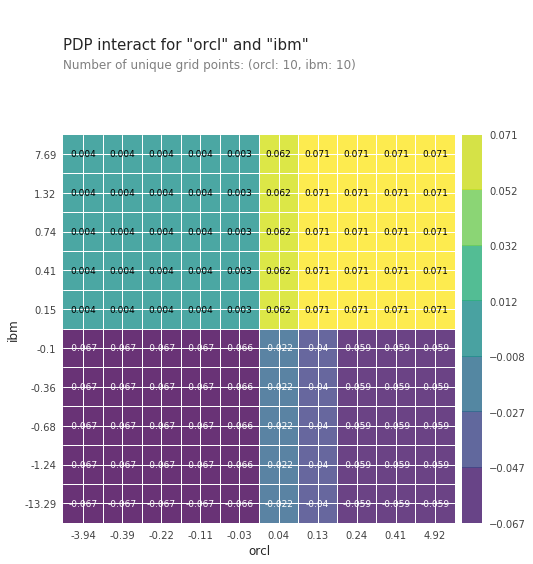

In [0]:
features = ['orcl', 'ibm']
interaction = pdp_interact(
    model=pipeline, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [0]:
interaction.pdp.head(3)

,orcl,ibm,preds
0,-3.935595,-13.291061,-0.066618
1,-3.935595,-1.243894,-0.066618
2,-3.935595,-0.681153,-0.066618


In [0]:
features = ['orcl', 'ibm']
interaction = pdp_interact(
    model=pipeline, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=features,
#     num_grid_points=[50,50] # takes long time and unnessary
)
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending
# plt.figure(figsize=(10,8))
# sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
# plt.title('Partial Dependence of Interest Rate');

In [0]:
surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values,
    colorbar=dict(thickness=10,
                  len=0.7)
)
layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    width=450, height=350
)
fig = go.Figure(surface, layout)
fig.show()